In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from tasks.markov import *
from models.base_models import *
from models.pos_encoder import *
from models.forward_tracer import *
from tasks.test_markov import *
from config import *
from train import *
import figures.plot as plot
from figures.ood_plots import *
from util import *
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange
import os
import re
import numpy as np
import matplotlib.pyplot as plt

from figures.head_view import *

torch.set_printoptions(precision=3, sci_mode=False)

%load_ext autoreload
%autoreload 2

In [2]:
# For comments, see TriggerMorkov.ipynb
def run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, 
            total_trans, alpha, pos_enc="rotary", hidden_dim=128,
            mlp_layers=None, epochs=10000, num_layers=2, show=False):

    flash = False
    
    if pos_enc in ["rotary", "abs"]:
        flash = True

    if mlp_layers is None:
        mlp_layers = [i for i in range(num_layers)]
        
    mlp = [False] * num_layers
    for i in mlp_layers:
        mlp[i] = True 
    mlp = tuple(mlp)
    
    config = Config(
            emb_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=tuple([1]*num_layers),
            identity_query=False,
            seq_len=SEQ_LEN,
            vocab_size=VOC_SIZE,
            batch_size=BATCH_SIZE,
            num_epochs=epochs,
            eval_iter=1000,
            pos_enc=pos_enc,
            pos_max_len=SEQ_LEN,
            get_attn=500,
            get_checkpoints=200,
            mlp=mlp,
            activation=mlp,
            flash=flash, # Use rotary
            ff_dim=hidden_dim,
            layer_norm=False,
            ngram=2,
            learning_rate=1e-4,
            task_name="latent"
        )

    sampler_config = LatentMarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, total_trans=total_trans, alpha=alpha,
                                               batch_size=BATCH_SIZE, task_name="latent")
    
    model = Transformer(config)
    model = model.to(config.device)

    train_results = train_model_with_plot(model, config, sampler_config, show=show)

    return train_results, model

In [91]:
# For comments, see TriggerMorkov.ipynb
def run_exp_icl(SEQ_LEN, VOC_SIZE, BATCH_SIZE, alpha, pos_enc="rotary", hidden_dim=128,
                mlp_layers=None, epochs=10000, num_layers=2, show=False):

    flash = False
    
    if pos_enc in ["rotary", "abs"]:
        flash = True

    if mlp_layers is None:
        mlp_layers = [i for i in range(num_layers)]
        
    mlp = [False] * num_layers
    for i in mlp_layers:
        mlp[i] = True 
    mlp = tuple(mlp)
    
    config = Config(
            emb_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=tuple([1]*num_layers),
            identity_query=False,
            seq_len=SEQ_LEN,
            vocab_size=VOC_SIZE,
            batch_size=BATCH_SIZE,
            num_epochs=epochs,
            eval_iter=1000,
            pos_enc=pos_enc,
            pos_max_len=SEQ_LEN,
            get_attn=500,
            get_checkpoints=200,
            mlp=mlp,
            activation=mlp,
            flash=flash, # Use rotary
            ff_dim=hidden_dim,
            layer_norm=False,
            ngram=2,
            learning_rate=1e-4,
            task_name="icl-mc"
        )

    sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, order=1, alpha=alpha,
                                         batch_size=BATCH_SIZE, task_name="icl-mc")
    
    model = Transformer(config)
    model = model.to(config.device)

    train_results = train_model_with_plot(model, config, sampler_config, show=show)

    return train_results, model

In [95]:
def kl_plot(model, SEQ_LEN, latent):
    B = 100
    kl_losses = np.zeros((B, SEQ_LEN))
    
    for b in range(B):
        batch, _ = sampler.test(latent=latent)
        kl_loss = F.kl_div(sampler.trans_matrix[latent][batch[0]].log(), nn.Softmax(dim=-1)(model(batch)[0])[0], reduction="none").sum(dim=-1)
        kl_loss = kl_loss.detach().cpu().numpy() 
        kl_losses[b] = kl_loss
    
    # Create a 1D NumPy array
    arr = np.arange(len(kl_loss))
    
    mean_losses = np.mean(kl_losses, axis=0)
    std_losses = np.std(kl_losses, axis=0)
    
    # Plot the array
    plt.plot(arr, mean_losses)
    plt.fill_between(arr, np.maximum(mean_losses - std_losses, 0), mean_losses + std_losses, color='blue', alpha=0.3, label="Mean ± 1 std")
    
    plt.grid()
    plt.title("Average KL-divergence at different positions")
    plt.xlabel("Positions")
    plt.ylabel("KL-divergence")
    
    plt.show()

In [112]:
SEQ_LEN, VOC_SIZE, BATCH_SIZE = 128, 5, 64
alpha = 1

total_trans = 3
print("Total number of transitions: ", total_trans)
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, total_trans, alpha, pos_enc="rotary", epochs=20000, num_layers=2)

sampler = train_results["sampler"]

Total number of transitions:  3


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Creating images:   0%|          | 0/21 [00:00<?, ?it/s]

Creating images:   0%|          | 0/21 [00:00<?, ?it/s]

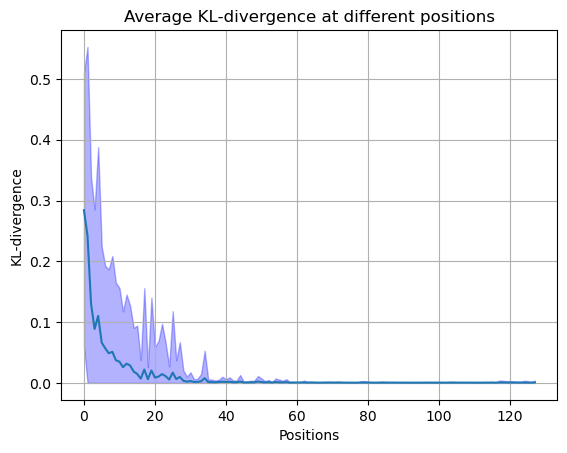

In [96]:
kl_plot(model, SEQ_LEN=SEQ_LEN, latent=0)

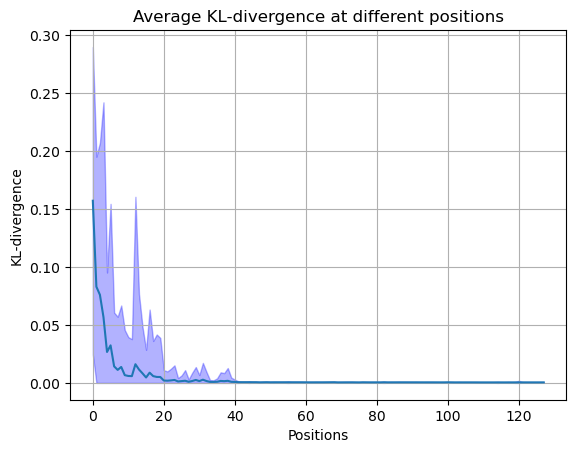

In [97]:
kl_plot(model, SEQ_LEN=SEQ_LEN, latent=1)

In [98]:
def get_task_vector(model, latent, seq_len, hidden_size, act_type="attn1", B=50):
    task_vec = torch.zeros((seq_len, hidden_size)).to("cuda")
    for b in range(B):
        batch, _ = sampler.test(latent=latent)
        tokens = model.embed(batch)
        hidden = model.layers[0].MHA(tokens, False)[0]
        if act_type == "attn0":
            task_vec += hidden[0]
            continue
        hidden = model.layers[0].mlp(tokens + hidden)
        if act_type == "mlp0":
            task_vec += hidden[0]
            continue
        tokens += model.layers[0](tokens)[0]
        hidden1 = model.layers[1].MHA(tokens, False)[0]
        if act_type == "attn1":
            task_vec += hidden1[0]
            continue
        hidden1 = model.layers[1].mlp(tokens + hidden1)
        task_vec += hidden1[0]
    return task_vec.detach().cpu().numpy() / B

def get_task_vector_ind(model, latent, seq_len, voc_size, hidden_size, pos=80, B=50):
    task_vec = torch.zeros((voc_size, hidden_size)).to("cuda")
    for b in range(B):
        batch, _ = sampler.test(latent=latent)
        for k in range(voc_size):
            batch[0][pos] = k
            tokens = model.embed(batch)
            tokens = model.layers[0](tokens)[0]
            hidden1 = model.layers[1].MHA(tokens, False)[0]
            task_vec[k] += hidden1[0][pos]
    return task_vec.detach().cpu().numpy() / B

def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size)/window_size, mode='valid')


def hidden_injection(batch, model, task_vec, act_type, pos=80):
    batch_size, seq_len = batch.shape
    tokens = model.embed(batch)
    task_vec = torch.from_numpy(task_vec).to("cuda")
    if pos is not None:
        task_vec = task_vec[pos:].mean(axis=0)
    if act_type == "mlp1":
        tokens += task_vec
    elif act_type == "attn1":
        tokens += task_vec
        tokens += model.layers[1].mlp(tokens)
    elif act_type == "mlp0":
        tokens += task_vec
        Q = model.layers[1].MHA.query(tokens).view(batch_size, seq_len, 1, 128).transpose(1,2) # (B,H,T,D)
        K = model.layers[1].MHA.key(tokens).view(batch_size, seq_len, 1, 128).transpose(1,2)
        V = model.layers[1].MHA.value(tokens).view(batch_size, seq_len, 1, 128).transpose(1,2)
        T = Q.size(2)
        # expected shape for apply_rotary_emb: (batch_size, max_seq_len, num_head, d_head)
        Q, K = apply_rotary_emb(Q.transpose(1, 2), K.transpose(1, 2), freqs_cis=model.layers[1].MHA.freqs_cis[:T])
        Q, K = Q.transpose(1, 2), K.transpose(1, 2)
        attn_score = Q @ K.transpose(-1,-2) / model.layers[1].MHA.scale
        attn = F.softmax(attn_score, dim=-1)

        diag_mask = torch.eye(T, dtype=tokens.dtype, device=tokens.device)  # Shape: (T, T)

        # Expand mask to match (B, H, T, T) using broadcasting
        diag_mask = diag_mask.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, T, T)
        
        # Apply the mask
        attn = attn * diag_mask
        out = attn @ V
        out = model.layers[1].MHA.out(out)
        tokens += out[0]
        tokens += model.layers[1].mlp(tokens)[0]
    else:
        tokens += task_vec
        tokens += model.layers[0].mlp(tokens)
        Q = model.layers[1].MHA.query(tokens).view(1, seq_len, 1, 128).transpose(1,2) # (B,H,T,D)
        K = model.layers[1].MHA.key(tokens).view(1, seq_len, 1, 128).transpose(1,2)
        V = model.layers[1].MHA.value(tokens).view(1, seq_len, 1, 128).transpose(1,2)
        T = Q.size(2)
        # expected shape for apply_rotary_emb: (batch_size, max_seq_len, num_head, d_head)
        Q, K = apply_rotary_emb(Q.transpose(1, 2), K.transpose(1, 2), freqs_cis=model.layers[1].MHA.freqs_cis[:T])
        Q, K = Q.transpose(1, 2), K.transpose(1, 2)
        attn_score = Q @ K.transpose(-1,-2) / model.layers[1].MHA.scale
        attn = F.softmax(attn_score, dim=-1)

        diag_mask = torch.eye(T, dtype=tokens.dtype, device=tokens.device)  # Shape: (T, T)

        # Expand mask to match (B, H, T, T) using broadcasting
        diag_mask = diag_mask.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, T, T)
        
        # Apply the mask
        attn = attn * diag_mask
        out = attn @ V
        out = model.layers[1].MHA.out(out)
        tokens += out[0]
        tokens += model.layers[1].mlp(tokens)[0]
    probs = nn.Softmax(dim=-1)(model.output_layer(tokens))
    return probs

def no_context(batch, model):
    tokens = model.embed(batch)
    tokens += model.layers[0].mlp(tokens)
    tokens += model.layers[1].mlp(tokens)
    probs = nn.Softmax(dim=-1)(model.output_layer(tokens))
    return probs

def hidden_injection_ind(batch, model, task_vec):
    tokens = model.embed(batch)
    task_vec = torch.from_numpy(task_vec).to("cuda")
    task_vec = task_vec[batch[0]]
    tokens += task_vec
    tokens += model.layers[1].mlp(tokens)
    probs = nn.Softmax(dim=-1)(model.output_layer(tokens))
    return probs

In [105]:
from sklearn.metrics.pairwise import cosine_similarity

def task_loss_plot(model, sampler, SEQ_LEN, latent, other, act_type, B=20, R=50):
    task_vecs = get_task_vector(model, other, SEQ_LEN, 128, act_type=act_type, B=R)

    kl_losses = np.zeros((B, SEQ_LEN))
    kl_losses_no_injection = np.zeros((B, SEQ_LEN))
    no_context_losses = np.zeros((B, SEQ_LEN))
    origin_losses = np.zeros((B, SEQ_LEN))
    
    for b in range(B):
        batch, _ = sampler.test(latent=latent)
        kl_loss_no_injection = F.kl_div(sampler.trans_matrix[other][batch[0]].log(), nn.Softmax(dim=-1)(model(batch)[0])[0], reduction="none").sum(dim=-1)
        origin_loss = F.kl_div(sampler.trans_matrix[latent][batch[0]].log(), nn.Softmax(dim=-1)(model(batch)[0])[0], reduction="none").sum(dim=-1)
        
        kl_loss = F.kl_div(sampler.trans_matrix[other][batch[0]].log(), hidden_injection(batch, model, task_vecs, act_type)[0], reduction="none").sum(dim=-1)
        
        no_context_prob = no_context(batch, model)
        no_context_loss = F.kl_div(sampler.trans_matrix[other][batch[0]].log(), no_context(batch, model)[0], reduction="none").sum(dim=-1)
        
        kl_losses[b] = kl_loss.detach().cpu().numpy() 
        no_context_losses[b] = no_context_loss.detach().cpu().numpy()
        origin_losses[b] = origin_loss.detach().cpu().numpy()
        kl_losses_no_injection[b] = kl_loss_no_injection.detach().cpu().numpy()
    
    arr = np.arange(len(kl_loss))
    
    mean_losses_o = np.mean(origin_losses, axis=0)
    std_losses_o = np.std(origin_losses, axis=0)
    
    mean_losses = np.mean(kl_losses, axis=0)
    std_losses = np.std(kl_losses, axis=0)
    
    mean_losses_no = np.mean(kl_losses_no_injection, axis=0)
    std_losses_no = np.std(kl_losses_no_injection, axis=0)
    
    mean_losses_no_c = np.mean(no_context_losses, axis=0)
    std_losses_no_c = np.std(no_context_losses, axis=0)
    
    # Plot the array
    plt.plot(arr, mean_losses)
    plt.fill_between(arr, np.maximum(mean_losses - std_losses, 0), mean_losses + std_losses, alpha=0.2, label="Task Vector")
    
    plt.plot(arr, mean_losses_no)
    plt.fill_between(arr, np.maximum(mean_losses_no - std_losses_no, 0), mean_losses_no + std_losses_no, alpha=0.2, label="Wrong Label")
    
    plt.plot(arr, mean_losses_o)
    plt.fill_between(arr, np.maximum(mean_losses_o - std_losses_o, 0), mean_losses_o + std_losses_o, alpha=0.2, label="Original")
    
    plt.plot(arr, mean_losses_no_c)
    plt.fill_between(arr, np.maximum(mean_losses_no_c - std_losses_no_c, 0), mean_losses_no_c + std_losses_no_c, alpha=0.2, label="No Context")
    
    plt.grid()
    plt.legend()
    plt.title("Average KL-divergence at different positions")
    plt.xlabel("Positions")
    plt.ylabel("KL-divergence")
    
    plt.show()


def task_loss_plot_ind(model, sampler, SEQ_LEN, voc_size, latent, other, B=20, R=50, pos=80):
    task_vecs = get_task_vector_ind(model, latent=other, seq_len=SEQ_LEN, voc_size=voc_size, hidden_size=128, pos=pos, B=R)

    kl_losses = np.zeros((B, SEQ_LEN))
    kl_losses_no_injection = np.zeros((B, SEQ_LEN))
    no_context_losses = np.zeros((B, SEQ_LEN))
    origin_losses = np.zeros((B, SEQ_LEN))
    
    for b in range(B):
        batch, _ = sampler.test(latent=latent)
        kl_loss_no_injection = F.kl_div(sampler.trans_matrix[other][batch[0]].log(), 
                                        nn.Softmax(dim=-1)(model(batch)[0])[0], reduction="none").sum(dim=-1)
        origin_loss = F.kl_div(sampler.trans_matrix[latent][batch[0]].log(), 
                               nn.Softmax(dim=-1)(model(batch)[0])[0], reduction="none").sum(dim=-1)
        
        kl_loss = F.kl_div(sampler.trans_matrix[other][batch[0]].log(), 
                           hidden_injection_ind(batch, model, task_vecs)[0], reduction="none").sum(dim=-1)
        
        no_context_prob = no_context(batch, model)
        no_context_loss = F.kl_div(sampler.trans_matrix[other][batch[0]].log(), no_context(batch, model)[0], reduction="none").sum(dim=-1)
        
        kl_losses[b] = kl_loss.detach().cpu().numpy() 
        no_context_losses[b] = no_context_loss.detach().cpu().numpy()
        origin_losses[b] = origin_loss.detach().cpu().numpy()
        kl_losses_no_injection[b] = kl_loss_no_injection.detach().cpu().numpy()
    
    arr = np.arange(len(kl_loss))
    
    mean_losses_o = np.mean(origin_losses, axis=0)
    std_losses_o = np.std(origin_losses, axis=0)
    
    mean_losses = np.mean(kl_losses, axis=0)
    std_losses = np.std(kl_losses, axis=0)
    
    mean_losses_no = np.mean(kl_losses_no_injection, axis=0)
    std_losses_no = np.std(kl_losses_no_injection, axis=0)
    
    mean_losses_no_c = np.mean(no_context_losses, axis=0)
    std_losses_no_c = np.std(no_context_losses, axis=0)
    
    # Plot the array
    plt.plot(arr, mean_losses)
    plt.fill_between(arr, np.maximum(mean_losses - std_losses, 0), mean_losses + std_losses, alpha=0.2, label="Task Vector")
    
    plt.plot(arr, mean_losses_no)
    plt.fill_between(arr, np.maximum(mean_losses_no - std_losses_no, 0), mean_losses_no + std_losses_no, alpha=0.2, label="Wrong Label")
    
    plt.plot(arr, mean_losses_o)
    plt.fill_between(arr, np.maximum(mean_losses_o - std_losses_o, 0), mean_losses_o + std_losses_o, alpha=0.2, label="Original")
    
    plt.plot(arr, mean_losses_no_c)
    plt.fill_between(arr, np.maximum(mean_losses_no_c - std_losses_no_c, 0), mean_losses_no_c + std_losses_no_c, alpha=0.2, label="No Context")
    
    plt.grid()
    plt.legend()
    plt.title("Average KL-divergence at different positions")
    plt.xlabel("Positions")
    plt.ylabel("KL-divergence")
    
    plt.show()

def task_vec_diff_viz(model, act_type, SEQ_LEN, latents, ws=2):
    ws = ws
    for l in range(latents):
        task_vecs = get_task_vector(model, l, SEQ_LEN, 128, act_type=act_type, B=50)
        diff_norm = np.linalg.norm(task_vecs[1:] - task_vecs[:-1], axis=1) / np.linalg.norm(task_vecs[1:], axis=1)
        arr = np.arange(len(diff_norm)-ws+1)
        plt.plot(arr, moving_average(diff_norm, ws), label=f"Difference when latent is {l}")
    
    plt.title("Relative Scales")
    plt.legend()
    plt.show()

def task_vec_sim_viz(model, act_type, SEQ_LEN, latents, ws=2):
    ws = ws
    if latents == 2:
        task_vecs0 = get_task_vector(model, 0, SEQ_LEN, 128, act_type=act_type, B=50)
        task_vecs1 = get_task_vector(model, 1, SEQ_LEN, 128, act_type=act_type, B=50)
        cosine_similarities0 = np.array([
            cosine_similarity(task_vecs0[t:t+1], task_vecs0[t+1:t+2])[0, 0]
            for t in range(SEQ_LEN-1)
        ])
        cosine_similarities1 = np.array([
            cosine_similarity(task_vecs1[t:t+1], task_vecs1[t+1:t+2])[0, 0]
            for t in range(SEQ_LEN-1)
        ])
        cosine_similarities01 = np.array([
            cosine_similarity(task_vecs0[t:t+1], task_vecs1[t:t+1])[0, 0]
            for t in range(SEQ_LEN-1)
        ])
        arr = np.arange(len(cosine_similarities0)-ws+1)
        plt.plot(arr, moving_average(cosine_similarities0, ws), label=f"Latent: 0")
        plt.plot(arr, moving_average(cosine_similarities1, ws), label=f"Latent: 1")
        plt.plot(arr, moving_average(cosine_similarities01, ws), label=f"Cross")
    
    else:
        for l in range(latents):
            task_vecs = get_task_vector(model, l, SEQ_LEN, 128, act_type=act_type, B=50)
            cosine_similarities = np.array([
                cosine_similarity(task_vecs[t:t+1], task_vecs[t+1:t+2])[0, 0]
                for t in range(SEQ_LEN-1)
            ])
            arr = np.arange(len(cosine_similarities)-ws+1)
            plt.plot(arr, moving_average(cosine_similarities, ws), label=f"Latent: {l}")
            
    plt.title("Cosine Similarity")
    plt.legend()
    plt.show()


def task_vec_sim_viz_ind(model, SEQ_LEN, voc_size, latents, ws=2):
    ws = ws
    start = 50
    end = 90
    arr = np.arange(start, end-ws+1)
    for l in trange(latents):
        cos_sim = np.zeros(end-start)
        for pos in trange(start, end, leave=False):
            task_vecs0 = get_task_vector_ind(model, l, SEQ_LEN, voc_size, 128, pos=pos-1, B=5)
            task_vecs1 = get_task_vector_ind(model, l, SEQ_LEN, voc_size, 128, pos=pos, B=5)
            cos_sim[pos-start] = task_vecs0.reshape(-1).dot(task_vecs1.reshape(-1)) / (np.linalg.norm(task_vecs0) * np.linalg.norm(task_vecs1))

        plt.plot(arr, moving_average(cos_sim, ws), label=f"Latent {l}")

    plt.title("Cosine Similarity")
    plt.legend()
    plt.show()

def task_vec_cos_sim(model, SEQ_LEN, voc_size, latents):
    start = 85
    end = 90
    task_vecs = np.zeros((latents*voc_size*(end-start), 128))

    for l in trange(latents):
        for k in trange(voc_size, leave=False):
            for pos in trange(start, end, leave=False):
                ind = l*voc_size*(end-start)+k*(end-start)+pos-start
                task_vecs[ind] = get_task_vector_ind(model, l, SEQ_LEN, voc_size, 128, pos=pos, B=5)[k]

    task_vecs = torch.from_numpy(task_vecs)
    task_vecs = F.normalize(task_vecs, p=2, dim=1)

    cosine_sim_matrix = torch.mm(task_vecs, task_vecs.T) 
    plt.figure(figsize=(8, 6))
    plt.imshow(cosine_sim_matrix.numpy(), cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Cosine Similarity")
    plt.title("Cosine Similarity Matrix Heatmap")
    plt.xlabel("Row Index")
    plt.ylabel("Row Index")
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

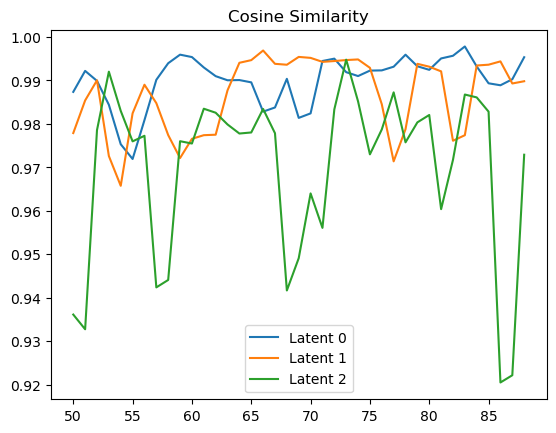

In [113]:
task_vec_sim_viz_ind(model, SEQ_LEN, VOC_SIZE, latents=3, ws=2)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

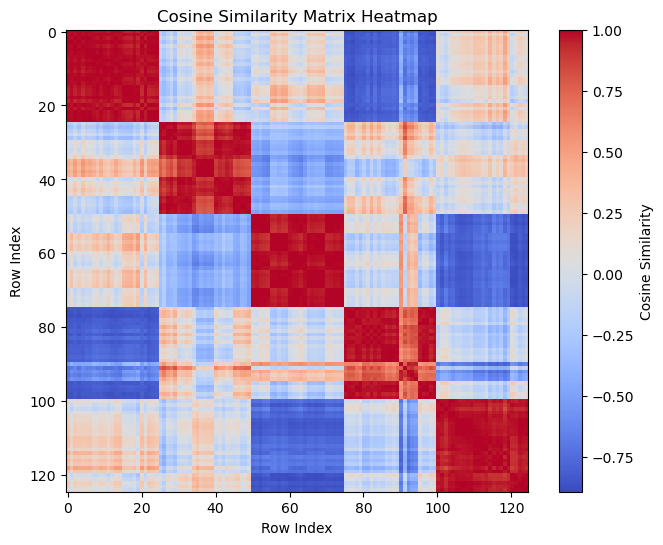

In [80]:
task_vec_cos_sim(model, SEQ_LEN, 5, 5)

In [81]:
batch, _ = sampler.test(latent=1)
task_vecs = get_task_vector_ind(model, latent=0, seq_len=SEQ_LEN, voc_size=5, hidden_size=128, pos=80, B=5)
torch.unique(hidden_injection_ind(batch, model, task_vecs)[0], dim=0).detach().cpu()

tensor([[0.046, 0.017, 0.459, 0.077, 0.402],
        [0.215, 0.152, 0.313, 0.105, 0.215],
        [0.226, 0.065, 0.141, 0.525, 0.044],
        [0.330, 0.218, 0.209, 0.149, 0.093],
        [0.373, 0.283, 0.186, 0.064, 0.093]])

In [82]:
torch.unique(sampler.trans_matrix[0][batch[0]], dim=0).cpu()

tensor([[0.090, 0.024, 0.491, 0.088, 0.307],
        [0.237, 0.083, 0.305, 0.190, 0.184],
        [0.245, 0.033, 0.112, 0.580, 0.030],
        [0.318, 0.269, 0.204, 0.129, 0.080],
        [0.484, 0.177, 0.191, 0.068, 0.080]])

In [83]:
F.kl_div(torch.unique(sampler.trans_matrix[0][batch[0]], dim=0).cpu().log(), 
         torch.unique(hidden_injection_ind(batch, model, task_vecs)[0], dim=0).detach().cpu(), reduction="none").sum(dim=-1)

tensor([0.029, 0.049, 0.021, 0.008, 0.042])

### Use the average hidden state from the last attention output as the task vector

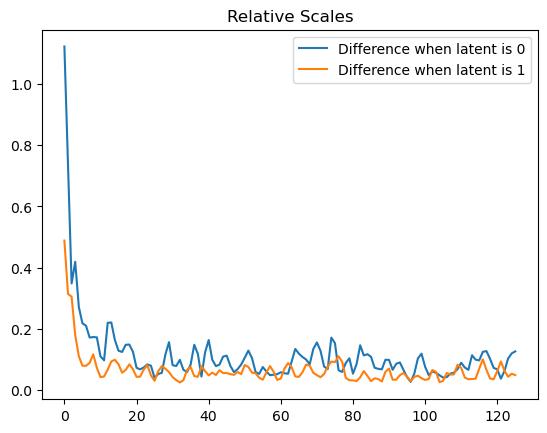

In [100]:
act_type = "attn1"

task_vec_diff_viz(model, act_type, SEQ_LEN, latents=2)

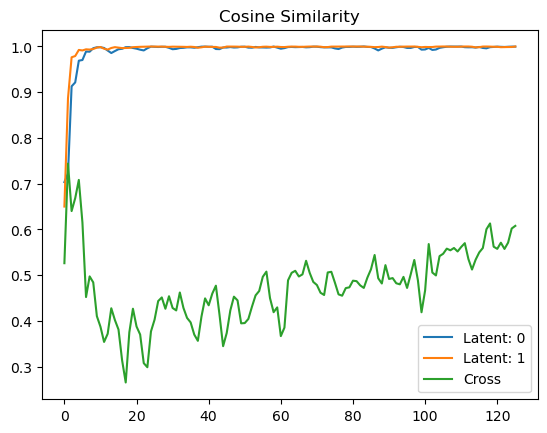

In [106]:
task_vec_sim_viz(model, act_type, SEQ_LEN, latents=2, ws=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

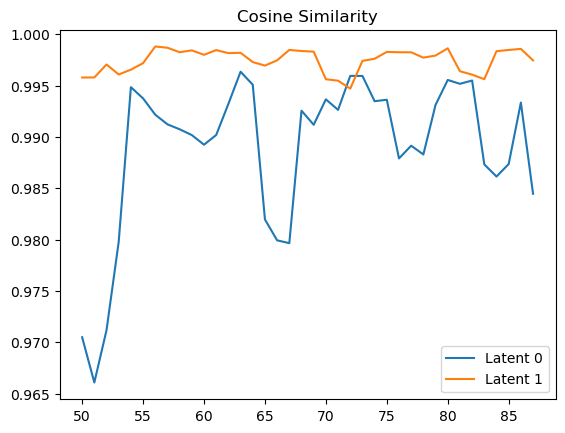

In [107]:
task_vec_sim_viz_ind(model, SEQ_LEN, 5, latents=2, ws=3)

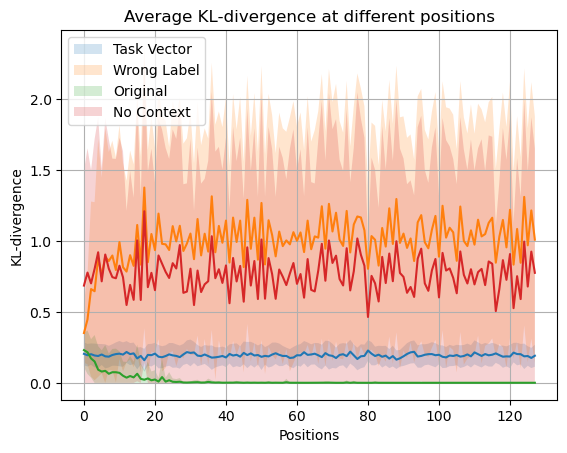

In [279]:
act_type = "attn1"
task_loss_plot(model, sampler, SEQ_LEN, latent=1, other=0, act_type=act_type, B=50, R=100)

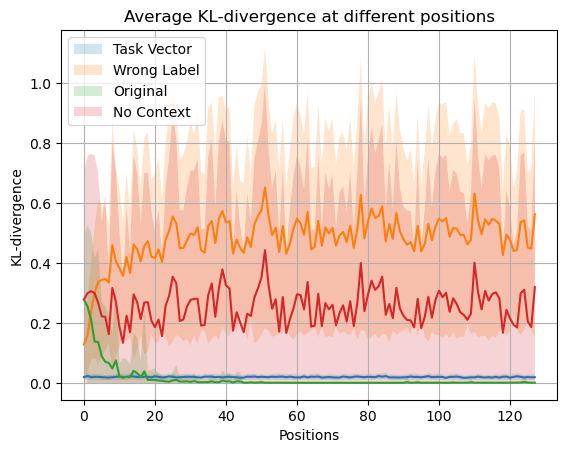

In [108]:
task_loss_plot_ind(model, sampler, SEQ_LEN, voc_size=5, latent=0, other=1, B=50, R=10)

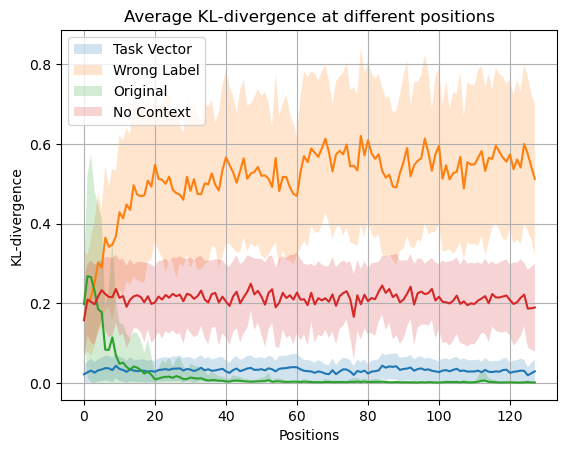

In [52]:
task_loss_plot_ind(model, sampler, SEQ_LEN, voc_size=5, latent=1, other=2, B=50, R=10, pos=90)

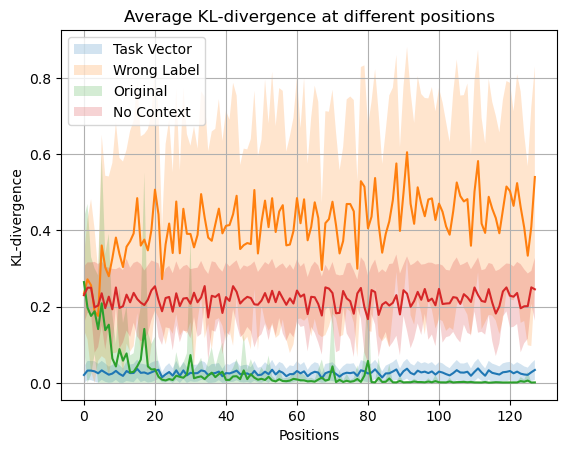

In [36]:
task_loss_plot_ind(model, sampler, SEQ_LEN, voc_size=5, latent=0, other=2, B=20, R=5)

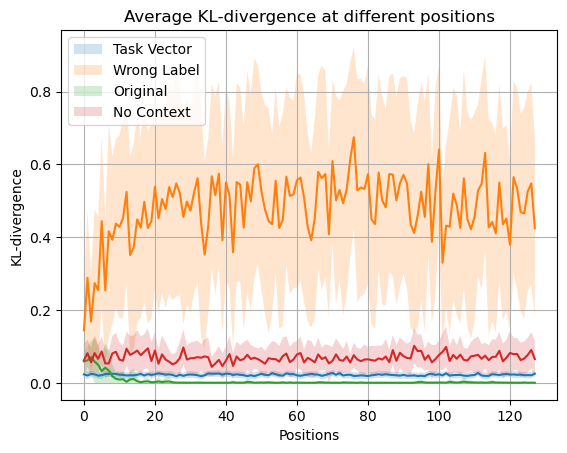

In [221]:
task_loss_plot(model, sampler, SEQ_LEN, latent=0, other=1, act_type=act_type, B=20)

### Use the average hidden state from the last MLP output as the task vector

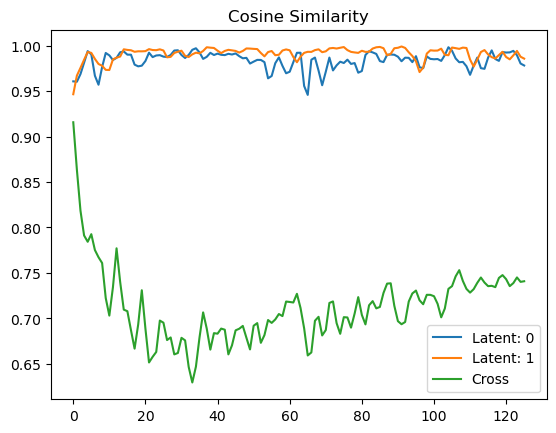

In [110]:
act_type = "mlp1"

task_vec_sim_viz(model, act_type, SEQ_LEN, latents=2)

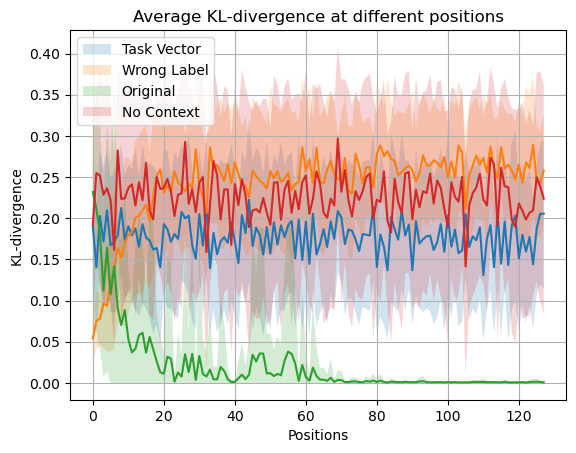

In [181]:
task_loss_plot(model, sampler, SEQ_LEN, latent=1, other=0, act_type=act_type, B=20)

### Use the average hidden state from the first MLP output as the task vector

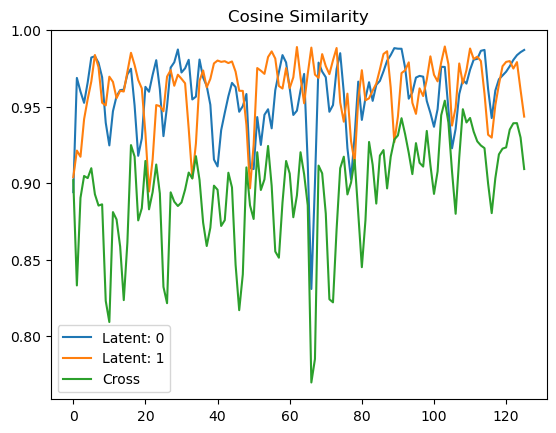

In [111]:
act_type = "mlp0"

task_vec_sim_viz(model, act_type, SEQ_LEN, latents=2)

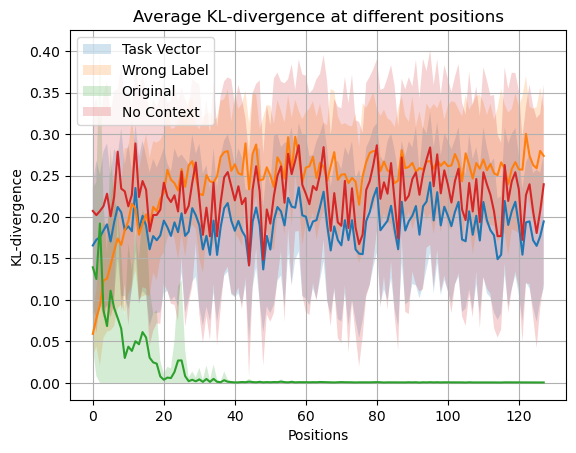

In [196]:
task_loss_plot(model, sampler, SEQ_LEN, latent=1, other=0, act_type=act_type, B=20)

### Use the average hidden state from the first Attention output as the task vector

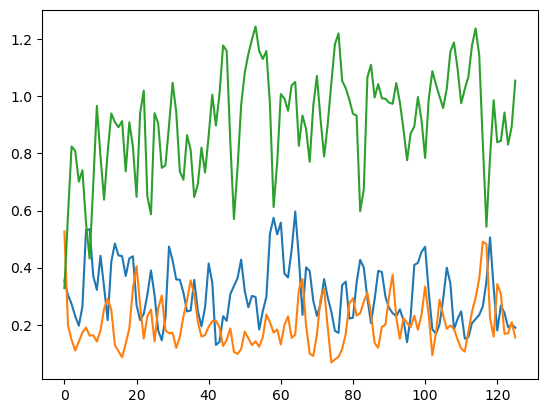

In [197]:
act_type = "attn0"

task_vec_diff_viz(model, act_type, SEQ_LEN)

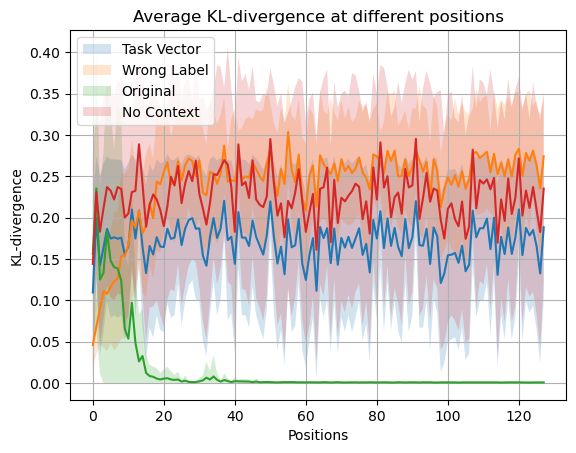

In [198]:
task_loss_plot(model, sampler, SEQ_LEN, latent=1, other=0, act_type=act_type, B=20)

### OOD Generalization

In [88]:
path = "checkpoints/latent/MLP1/"
alphas = [0.1, 0.6, 1] 
id_results, ood_results, check_results = get_ood_id(path, alphas)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [165]:
np.save(f"{path}id_results.npy", id_results)
np.save(f"{path}ood_results.npy", ood_results)
with open(f"{path}check_results.pkl", "wb") as f:
    pickle.dump(check_results, f)

In [ ]:
train_results_icl, model_icl = run_exp_icl(SEQ_LEN, VOC_SIZE, BATCH_SIZE, alpha, pos_enc="rotary", mlp_layers=[1], epochs=15000, num_layers=2)

In [163]:
path = "checkpoints/icl-mc/20250301_0039/"
alphas = [0.1, 0.6, 1]
id_results_icl, ood_results_icl, check_results_icl = get_ood_id_icl(path, alphas)

  0%|          | 0/75 [00:00<?, ?it/s]

alpha:  0.1
Unigram Losses Mean: 0.884
Bigram Losses Mean: 0.379
alpha:  0.6
Unigram Losses Mean: 1.445
Bigram Losses Mean: 1.072
alpha:  1
Unigram Losses Mean: 1.509
Bigram Losses Mean: 1.230


Unigram Losses Mean: 1.508
Bigram Losses Mean: 1.232
Unigram Losses Mean: 0.908
Bigram Losses Mean: 0.387


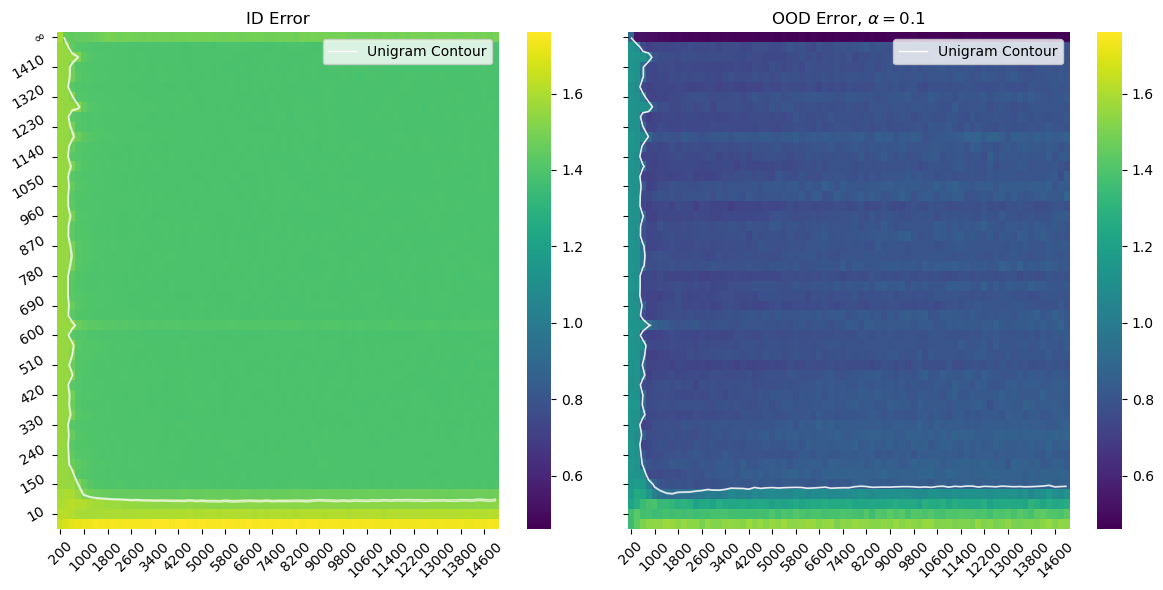

In [171]:
ood_id_plot(0.1, "checkpoints/latent/MLP1/", id_results_icl, ood_results_icl, id_results, ood_results, check_results)

Unigram Losses Mean: 1.508
Bigram Losses Mean: 1.232
Unigram Losses Mean: 0.896
Bigram Losses Mean: 0.386


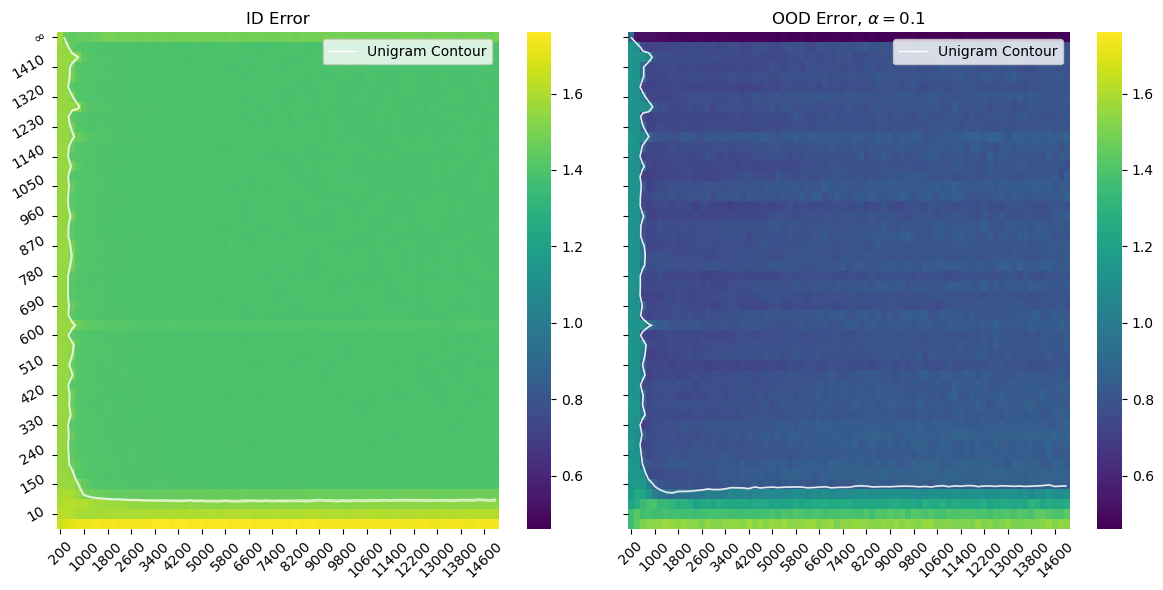

In [172]:
ood_id_plot(0.6, "checkpoints/latent/MLP1/")

### Interpreting small latent markov

Let us try to understand what transformer is doing for small number of hidden latent variables. Consider 2 Markov chains, the transformer will focus on small features, such as the presence of $(2,4)$ if $(2,4)$ has very different occuring probabilities. 

Let us start with interpreting the behaviour of 1. For the first layer, 1 would attend to its own, so we have
$$
\bar{x}_t \approx x_t + W_{OV}^{(1)} x_t.
$$
For the second layer, 1 would mostly attend to 4. In the first layer, 4 has a previous token head if the previous one is not 1. So for 4, we have
$$
\bar{x}_t \approx x_t + \frac{1}{2} W_{OV}^{(1)} x_t + \frac{1}{2} W_{OV}^{(1)} x_{t-1}
$$
$$
\tilde{x}_t \approx \bar{x}_t + \sum_{s} \alpha_s W_{OV}^{(2)} \bar{x}_{s} = x_t + W_{OV}^{(1)} x_t + \text{How many (2,4) occurs}
$$

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sampler = train_results["sampler"]
OV1 = model.layers[0].MHA.value.weight.T @ model.layers[0].MHA.out.weight.T
OV2 = model.layers[1].MHA.value.weight.T @ model.layers[1].MHA.out.weight.T
range_toks = model.embed(torch.arange(VOC_SIZE, device=device))
static_info = range_toks + range_toks @ (OV1 + OV2 + OV1@OV2)

In [15]:
batch = sampler.test()[0]
toks = model.embed(batch)
toks = model.layers[0](toks, False)[0]
tok = model.embed(torch.tensor([1]))
(toks[batch == 1] - tok - tok @ OV1).norm(dim=-1)

Latent variable:  0


tensor([0.050, 0.642, 0.693, 1.315, 1.047, 0.670, 0.650, 0.715, 0.952, 0.752,
        0.631, 0.489, 0.547, 0.779, 1.700, 1.571, 1.210, 1.250, 1.405, 1.031],
       grad_fn=<LinalgVectorNormBackward0>)

In [160]:
mlp_out = model.layers[1].mlp(static)
probs = nn.Softmax(dim=-1)(model.output_layer(static + mlp_out))
probs

tensor([[0.083, 0.306, 0.425, 0.046, 0.139],
        [0.158, 0.245, 0.345, 0.186, 0.066],
        [0.121, 0.327, 0.260, 0.185, 0.107],
        [0.263, 0.069, 0.283, 0.304, 0.082],
        [0.043, 0.179, 0.354, 0.141, 0.282]], grad_fn=<SoftmaxBackward0>)

Latent variable:  0


<Axes: >

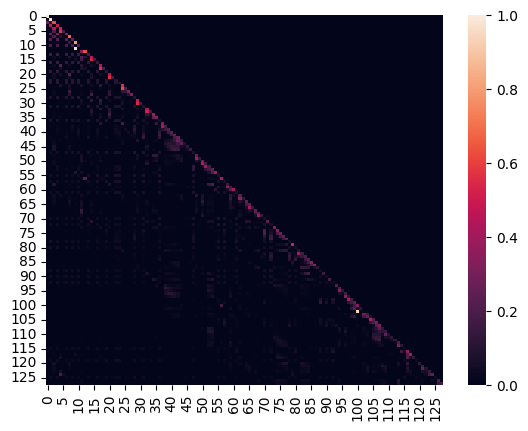

In [19]:
probe, _ = sampler.test(latent=0)
attn0 = get_attn(probe, layer = 0)
sns.heatmap(attn0.detach().numpy().squeeze(0).squeeze(0))
plt.show()

<Axes: >

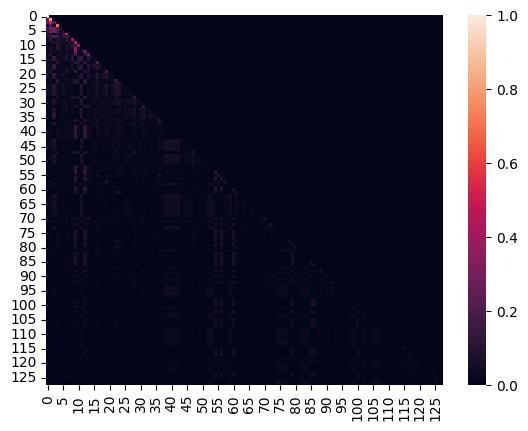

In [20]:
attn1 = get_attn(probe, layer = 1)
sns.heatmap(attn1.detach().numpy().squeeze(0).squeeze(0))
plt.show()

<Axes: >

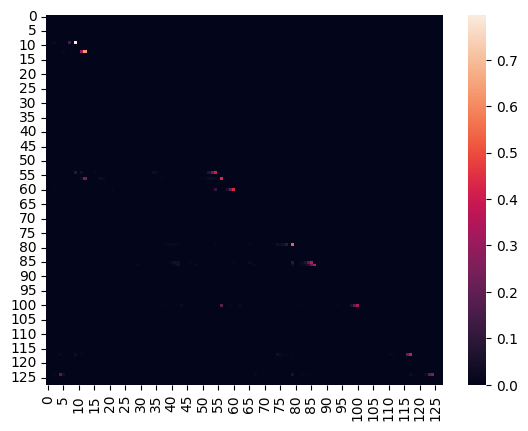

In [24]:
mask = (probe[0]!=4).unsqueeze(1).repeat(1,128)
sns.heatmap(attn0[0][0].masked_fill(mask, 0).detach().numpy())

In [246]:
get_head_view(model, train_results, train_results["config"], trunc=0, action='view', batch=probe_tensor)

<IPython.core.display.Javascript object>

In [234]:
tok = 3
F.kl_div(sampler.trans_matrix[1][tok].log(), nn.Softmax(dim=-1)(model(probe_tensor)[0])[probe==tok], reduction="none").sum(dim=-1)

tensor([    0.001,     0.000,     0.000,     0.000,     0.062,     0.047,
            0.036,     0.075,     0.149,     0.158,     0.161,     0.156,
            0.107,     0.200,     0.170,     0.177,     0.190,     0.190,
            0.189,     0.222,     0.222,     0.223,     0.238,     0.248,
            0.249,     0.249,     0.248,     0.234,     0.235,     0.224],
       grad_fn=<SumBackward1>)

In [48]:
F.cosine_similarity(context0.unsqueeze(1), context0.unsqueeze(0), dim=-1)

tensor([[ 1.000, -0.838, -0.647,  0.783, -0.872],
        [-0.838,  1.000,  0.893, -0.888,  0.989],
        [-0.647,  0.893,  1.000, -0.907,  0.884],
        [ 0.783, -0.888, -0.907,  1.000, -0.882],
        [-0.872,  0.989,  0.884, -0.882,  1.000]], grad_fn=<SumBackward1>)

In [54]:
mlp_out = model.layers[1].mlp(static_info)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + mlp_out)).mean(dim=0)
target = (sampler.trans_matrix[0] + sampler.trans_matrix[1]) / 2
F.kl_div(target.log(), probs, reduction="none").sum(dim=-1)

tensor([0.110, 0.053, 0.046, 0.214, 0.111], grad_fn=<SumBackward1>)

In [178]:
probs = nn.Softmax(dim=-1)(model.output_layer(static + context0_avg + model.layers[1].mlp(static + context0_avg)))
target = sampler.trans_matrix[0]
F.kl_div(target.log(), probs, reduction="none").sum(dim=-1)

tensor([0.017, 0.041, 0.005, 0.007, 0.136], grad_fn=<SumBackward1>)

In [176]:
mlp_out = model.layers[1].mlp(static + context1_avg)
probs = nn.Softmax(dim=-1)(model.output_layer(static + context1_avg + mlp_out))
target = sampler.trans_matrix[1]
F.kl_div(target.log(), probs, reduction="none").sum(dim=-1)

tensor([0.026, 0.029, 0.040, 0.001, 0.033], grad_fn=<SumBackward1>)

In [77]:
tok = 0
context_tok = context[batch==tok][-5:].mean(dim=0)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_tok + model.layers[1].mlp(static_info+context_tok)))[batch==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.002, device='cuda:0', grad_fn=<SumBackward0>)

In [58]:
tok = 4
context_other = context[batch==2][-5:].mean(dim=0)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_other + model.layers[1].mlp(static_info + context_other)))[batch==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.157, device='cuda:0', grad_fn=<SumBackward0>)

In [48]:
F.kl_div(sampler.trans_matrix[0][0].log(), nn.Softmax(dim=-1)(model(batch)[0])[batch==0], reduction="none").sum(dim=-1)

tensor([0.055, 0.003, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.003,
        0.003, 0.003, 0.002, 0.002], device='cuda:0', grad_fn=<SumBackward1>)

In [51]:
tok = 3
F.kl_div(sampler.trans_matrix[0][tok].log(), nn.Softmax(dim=-1)(model(batch)[0])[batch==tok], reduction="none").sum(dim=-1)

tensor([0.018, 0.016, 0.014, 0.001, 0.002, 0.001, 0.001, 0.004, 0.002, 0.002,
        0.002, 0.003, 0.001, 0.001, 0.003, 0.002, 0.002, 0.002, 0.002, 0.004,
        0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.002, 0.002, 0.002],
       device='cuda:0', grad_fn=<SumBackward1>)